In [1]:
%matplotlib inline
from sklearn import datasets
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

In [2]:
iris = datasets.load_iris()
X = iris.data
Y = iris.target

In [3]:
D = X.shape[1]
mean = np.mean(X, axis=0)
cov = np.cov(X.T)
mean, cov

(array([5.84333333, 3.05733333, 3.758     , 1.19933333]),
 array([[ 0.68569351, -0.042434  ,  1.27431544,  0.51627069],
        [-0.042434  ,  0.18997942, -0.32965638, -0.12163937],
        [ 1.27431544, -0.32965638,  3.11627785,  1.2956094 ],
        [ 0.51627069, -0.12163937,  1.2956094 ,  0.58100626]]))

In [4]:
n_dim = L = 2
e_values, e_vectors = np.linalg.eigh(cov)
e_values = np.flip(e_values)
e_vectors = np.flip(e_vectors, axis=1)
e_vectors, e_values

(array([[-0.36138659,  0.65658877,  0.58202985,  0.31548719],
        [ 0.08452251,  0.73016143, -0.59791083, -0.3197231 ],
        [-0.85667061, -0.17337266, -0.07623608, -0.47983899],
        [-0.3582892 , -0.07548102, -0.54583143,  0.75365743]]),
 array([4.22824171, 0.24267075, 0.0782095 , 0.02383509]))

In [5]:
V = e_vectors[:, :n_dim]
Lambda = np.diag(e_values[:n_dim])
V, Lambda

(array([[-0.36138659,  0.65658877],
        [ 0.08452251,  0.73016143],
        [-0.85667061, -0.17337266],
        [-0.3582892 , -0.07548102]]),
 array([[4.22824171, 0.        ],
        [0.        , 0.24267075]]))

In [6]:
sigma = 1 / (D - L) * np.sum(e_values[L+1:])
sigma_I = sigma*np.eye(L)

W = V.dot(np.sqrt(Lambda - sigma_I))

M = W.T.dot(W) + sigma_I

In [7]:
def project(X, mean, M_inv, W, sigma):
    new_mean = M_inv.dot(W.T).dot((X - mean).T).T
#     new_sigma = sigma*M_inv
#     z = np.random.multivariate_normal(new_mean, new_sigma, 1)[0]
    return new_mean # retornando apenas a experança

M_inv = np.linalg.inv(M)
z = project(X, mean, M_inv, W, sigma)
z.shape

(150, 2)

In [8]:
W.dot(z[0].T).T.shape, mean.T.shape

((4,), (4,))

In [9]:
def reconstruct(z, mean, W, sigma):
    new_mean = W.dot(z.T).T + mean
#     x = np.random.multivariate_normal(new_mean, sigma*np.eye(D), 1)[0]
    return new_mean

x = reconstruct(z, mean, W, sigma)
x[0]

array([5.07547401, 3.50532148, 1.4124142 , 0.21742624])

In [10]:
np.abs(X[0] - x[0])

array([0.02452599, 0.00532148, 0.0124142 , 0.01742624])

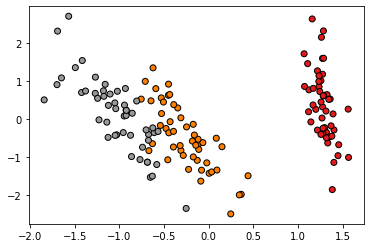

In [11]:
# para plotar o meshgrid, temos de fazer o produtório das probabilidades dsa projeções pra todos os pontos dos dados
X_projected = project(X, mean, M_inv, W, sigma)
plt.scatter(X_projected[:, 0], X_projected[:, 1], c=Y, cmap=plt.cm.Set1,
            edgecolor='k')

In [12]:
def space_likelihood(z, X, mean, M_inv, W, sigma):
    means = M_inv.dot(W.T).dot((X - mean).T).T
    new_sigma = sigma*M_inv
    
    s = 0
    for x, m in zip(X, means):
        s += multivariate_normal.pdf(z, mean=m, cov=new_sigma)
    
    return s
    
space_likelihood(X_projected[0], X, mean, M_inv, W, sigma)

96.63216460530208

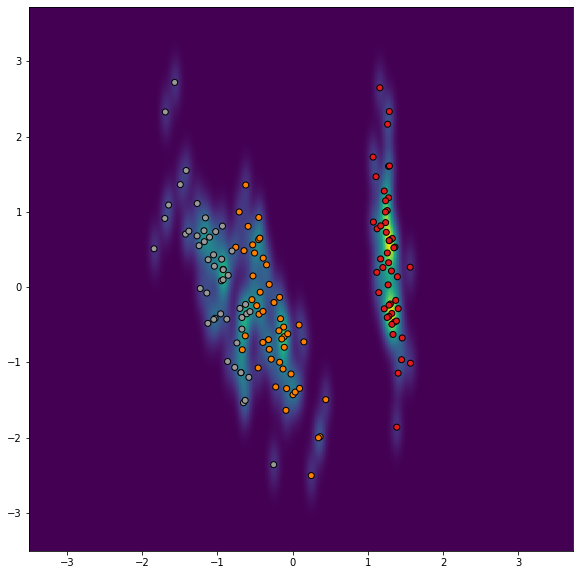

In [13]:
resolution = 200
margin = 0.5
x = y = np.linspace(X_projected.min()-margin,X_projected.max()+margin,resolution)
grid = np.dstack(np.meshgrid(x,y)).reshape(-1,2)

densities = np.array([space_likelihood(x, X, mean, M_inv, W, sigma) for x in grid]).reshape(resolution, resolution)
plt.figure(figsize=(10,10))
plt.imshow(densities, origin='lower', extent=(x[0],x[-1],y[0],y[-1]))
plt.scatter(X_projected[:, 0], X_projected[:, 1], c=Y, cmap=plt.cm.Set1,
            edgecolor='k')

### Comparando com o PCA do sklearn

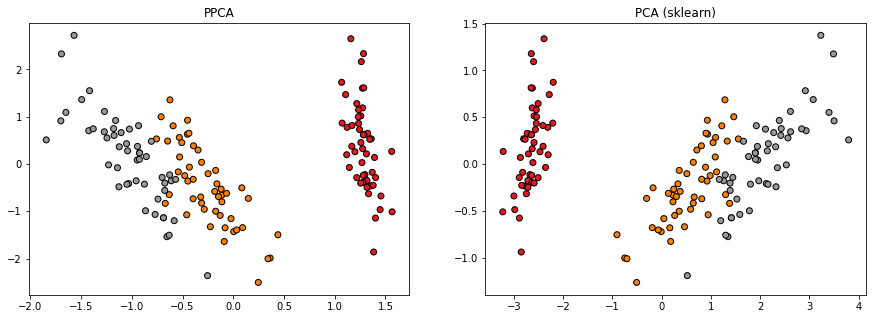

In [14]:
from sklearn.decomposition import PCA

plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
X_projected = np.array([project(x, mean, M_inv, W, sigma) for x in X])
plt.scatter(X_projected[:, 0], X_projected[:, 1], c=Y, cmap=plt.cm.Set1,
            edgecolor='k')
plt.title("PPCA")

plt.subplot(1,2,2)
pca = PCA(n_components=2)
X_projected = pca.fit(X).transform(X)

plt.scatter(X_projected[:, 0], X_projected[:, 1], c=Y, cmap=plt.cm.Set1,
            edgecolor='k')
_ = plt.title("PCA (sklearn)")

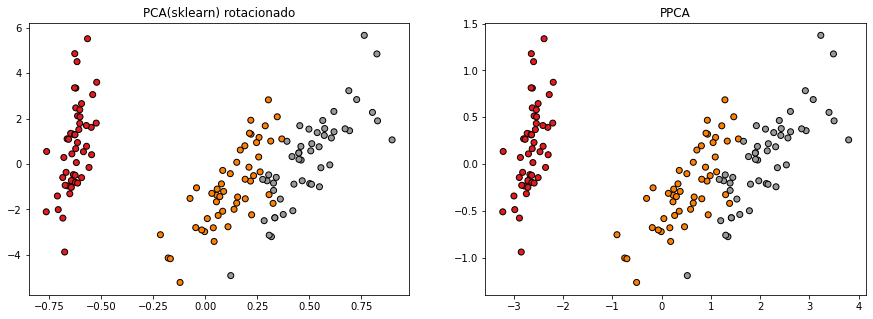

In [15]:
# estimando matriz de rotação
R = np.linalg.inv(W.T.dot(W)).dot(W.T).dot(pca.components_.T)

X_rot = project(X, mean, M_inv, W, sigma).dot(R)

plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.scatter(X_rot[:, 0], X_rot[:, 1], c=Y, cmap=plt.cm.Set1,
            edgecolor='k')
_ = plt.title(f"PCA(sklearn) rotacionado")

plt.subplot(1,2,2)
X_projected = pca.fit(X).transform(X)
plt.scatter(X_projected[:, 0], X_projected[:, 1], c=Y, cmap=plt.cm.Set1,
            edgecolor='k')
_ = plt.title("PPCA")